# Relationship between object and lens orientation angles in Scheimpflug imaging

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
%matplotlib inline

In [3]:
# Helper functions
sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))
arcsind = lambda x : np.rad2deg(np.arcsin(x))
arccosd = lambda x : np.rad2deg(np.arccos(x))
arctand = lambda x : np.rad2deg(np.arctan(x))

# Helper function for saving figures
curDir = os.getcwd()
imgdir = os.path.join(curDir, 'images')
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    print("Created 'images' directory")


bSaveFigure = True
fig_format, fig_ext = 'png', '.png'
def saveFigure(figure, fig_name, DPI=120):
    if bSaveFigure:
        figname = os.path.join(imgdir, fig_name)
        print('figname:', figname)
        figure.savefig(figname, dpi=DPI, facecolor='white', edgecolor='white',
                       bbox_inches='tight', format=fig_format, pad_inches=0.03)

### Index

1. [Rotation of lens about a pivot away from the ENPP](#Rotation-of-lens-about-a-pivot-away-from-the-ENPP)
2. [Lens rotated about the x-axis at ENPP](#Lens-rotated-about-the-x-axis-at-ENPP)
3. [Iterative algorithm for finding lens tilt angle α](#Iterative-algorithm-for-finding-lens-tilt-angle-$\alpha$)

## Rotation of lens about a pivot away from the ENPP

If the object plane is tilted about one axis (let's say the x-axis) by and angle $\beta$ (such that, it makes angle $\beta$ w.r.t. the vertical, y-axis), then the lens must also be rotated in the same direction (i.e. about the x-axis). If the angle of rotation of the lens is $\alpha$, then in order for the tilted object to be in focus, $\alpha$ and $\beta$ must satisfy the following relationship:

$$
\tan \,\beta = -\frac{\sin \,\alpha \left[ m_p(z_o - d_e \cos \,\alpha) + f(1-m_p) \cos \,\alpha \right]}{(f - m_p d_e \sin^2 \alpha)(m_p \cos^2 \alpha + \sin^2 \alpha)+m_p(1-m_p)d_e \sin^2 \alpha \, \cos^2 \alpha}
$$

We will often refer to the R.H.S. of the above equation as $g(\alpha, m_p, d_e, f, z_o)$.

#### Lens rotated about a changing pivot point

In [4]:
# Functions for analysing the effects of lens rotation

def get_beta_shifting_pivot(x, de, zo, f, mp, alpha):
    """compute the object tilt angle (orientation of PoSF) for lens tilted about the x-axis
    about a point (de + x) distance from the ENPP. 
    
    @param: x: increment in distance of ENPP from {C} in fronto-parallel configuration
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: zo: directed distance of object plane from {C} 
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    """
    c = cosd(alpha)
    s = sind(alpha)
    numr = s*( mp*(zo + x - (de + x)*c) + f*(1 - mp)*c)
    deno = (f - mp*(de + x)*s**2)*(mp*c**2 + s**2) + (de + x)*mp*(1-mp)*(s**2)*(c**2)
    return -arctand(numr/deno)

def get_beta(de, zo, f, mp, alpha):
    """compute the object tilt angle (orientation of PoSF) for lens tilted about the x-axis
    about a point (de) distance from the ENPP. 
    
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: zo: directed distance of object plane from {C} 
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    """
    return get_beta_shifting_pivot(0.0, de, zo, f, mp, alpha)

def get_zoDash(zo, alpha, beta, f, mp, de, deDash):
    """compute image plane distance (along z-axis of {C})
    
    @param: zo: directed distance of object plane from {C} 
    @param: alpha: angle of rotation (in degrees) of the lens about the pivot about x-axis
    @param: beta: angle of rotation (in degrees) of the object plane about it's pivot about x-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: de: directed distance of ENPP from {C} in fronto-parallel configuration.
    @param: deDash: directed distance of EXPP from {C} in fronto-parallel configuration.
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = tand(beta)
    z = zo - de*(s*t + c)
    numr = mp*f*(mp*c**2 + s**2)*z
    deno = mp*c*z + f
    return deDash*c + numr/deno

def get_tanBeta(de, zo, f, mp, alpha):
    """same as the function `get_beta()`, except that it returns tan(β) instead of beta
    """
    c = cosd(alpha)
    s = sind(alpha)
    numr = -s*(mp*(zo - de*c) + f*(1 - mp)*c)
    deno = (f - mp*de*s**2)*(mp*c**2 + s**2) + de*mp*(1-mp)*(s**2)*(c**2)
    return numr/deno

def beta_thin(zo, f, alpha):
    """compute beta using thin-lens approximation. If the lens is rotated about the ENPP
    and the pupil magnification equals one, then this relation is exact too.
    """
    return -arctand(zo*sind(alpha)/f)

In [5]:
# ex. optical system "paraxialDoubleLens24mmFiniteConj_mp2.zmx"
zo = -509.0
f = 24.0
mp = 2.0
de = -5.0        # along the optical axis
deDash = -25.0   # along the optical axis

#Image position (zoDash): 24.1707317
#Obj. distance from ENPP (|ze|): 504.0
#Image position from EXPP (|zeDash|): 49.1707316951

# First we ensure that the object-to-ENPP distance (ze) and EXPP-to-image distance (zeDash)
# remains fixed in frontoparallel configuration for different values of x.
alpha = 0
for x in range(3):
    zoNew = zo + x
    deNew = de + x
    deDashNew = deDash + x
    ze = zoNew - deNew*cosd(alpha)
    # since the function get_zoDash computes zoNew, and deNew we just pass zo and de (the initial values)
    beta = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alpha) 
    zoDash = get_zoDash(zo=zoNew, alpha=alpha, beta=beta, f=f, mp=mp, de=deNew, deDash=deDashNew)
    zeDash = zoDash - deDashNew*cosd(alpha)
    print(('zo = {:3.2f}, zoDash = {:3.2f}, d = {:3.2f}, ze = {:3.2f}, zeDash = {:3.2f}'
           .format(zoNew, zoDash, deDashNew - deNew, ze, zeDash)))

zo = -509.00, zoDash = 24.17, d = -20.00, ze = -504.00, zeDash = 49.17
zo = -508.00, zoDash = 25.17, d = -20.00, ze = -504.00, zeDash = 49.17
zo = -507.00, zoDash = 26.17, d = -20.00, ze = -504.00, zeDash = 49.17


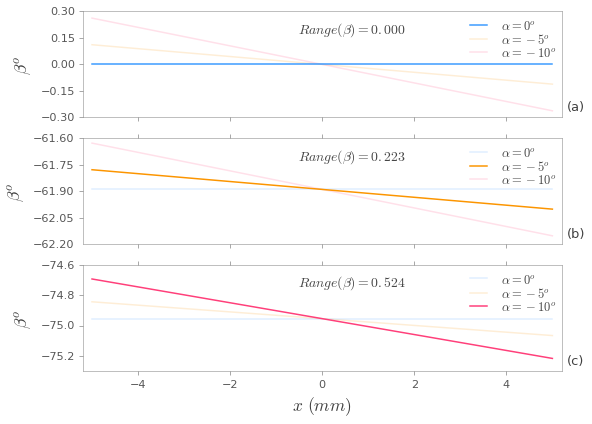

In [6]:
FIGURE_FOR_WORD = False

alphaArr = [0, -5, -10]

if FIGURE_FOR_WORD:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
    tsf = 1.25
    
(ax0, ax1, ax2) = axes.flatten()

x = np.linspace(-5, 5, 21)   # range of displacements

beta0 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[0])
beta1 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[1])
beta2 = get_beta_shifting_pivot(x=x, de=de, zo=zo, f=f, mp=mp, alpha=alphaArr[2])
beta0Mean = np.mean(beta0)
beta1Mean = np.mean(beta1)
beta2Mean = np.mean(beta2)

rangeBeta0 = '{:0.3f}'.format(np.max(beta0) - np.min(beta0))
rangeBeta1 = '{:0.3f}'.format(np.max(beta1) - np.min(beta1))
rangeBeta2 = '{:0.3f}'.format(np.max(beta2) - np.min(beta2))

# figure  (the figure and font size in the figure are optimized for saving for embedding into word)
#print(beta0Mean, beta1Mean, beta2Mean)
alphaLight = 0.16
lwLight = 1.5
lwEmph = 1.5

ax0.plot(x, beta0, color='#3A9AFF', lw=lwEmph, 
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=10)
ax0.plot(x, beta1 - beta1Mean,  color='#FC9500', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=8)
ax0.plot(x, beta2 - beta2Mean, color='#FF3F7A', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=8)
ax0.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta0), fontsize=11*tsf, transform=ax0.transAxes)
#
ax1.plot(x, beta0 + beta1Mean, color='#3A9AFF', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=8)
ax1.plot(x, beta1, color='#FC9500', lw=lwEmph,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=10)
ax1.plot(x, beta2 + (beta1Mean - beta2Mean), color='#FF3F7A', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=8)
ax1.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta1), fontsize=11*tsf, transform=ax1.transAxes)
#
ax2.plot(x, beta0 + beta2Mean, color='#3A9AFF', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[0]), zorder=8)
ax2.plot(x, beta1 + (beta2Mean - beta1Mean), color='#FC9500', alpha=alphaLight, lw=lwLight,
        label=r'$\alpha={}^o$'.format(alphaArr[1]), zorder=8)
ax2.plot(x, beta2, color='#FF3F7A', lw=lwEmph,
        label=r'$\alpha={}^o$'.format(alphaArr[2]), zorder=10)
ax2.text(0.45, 0.8, r'$Range(\beta)={}$'.format(rangeBeta2), fontsize=11*tsf, transform=ax2.transAxes)

# plot decorations
# common to all axes
for l, ax in zip(['(a)', '(b)', '(c)'], [ax0, ax1, ax2]):
    ax.set_xlim(x[0]-0.2, x[-1] + 0.2)                # x limit
    #ax.grid(axis='y', alpha=0.4)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))    # number of ticks
    ax.yaxis.set_ticks_position('left')               # tick 
    ax.set_ylabel(r'$\beta^o$', fontsize=14*tsf)          # y-label
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)
    # legend
    ax.legend(loc=(0.79, 0.5), labelspacing=0.008, fontsize=10*tsf)
    # subplot id label  
    ax.text(1.01, 0.065, l, fontsize=13, color='#404040', transform=ax.transAxes)
    
ax0.xaxis.set_ticks_position('bottom')
ax2.set_xlabel(r'$x\,\,(mm)$', fontsize=14*tsf)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'object_tilt_angle_with_pivot_movement.png')

plt.show()

<font color='red'>**Question**</font> For given $\alpha$ do we always get unique $\beta$?

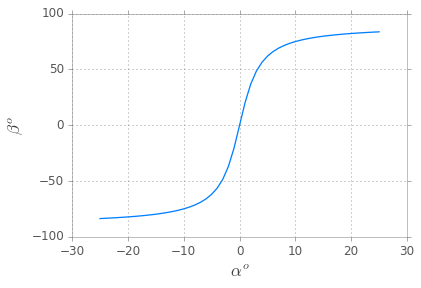

In [7]:
# plot of alpha vs. beta  
# this plot shows that given alpha, we can get a unique beta within +/-90°
alpha = np.linspace(-25., 25., 51)
beta = get_beta(de=-5.0, zo=-509.0, f=24.0, mp=2.0, alpha=alpha)

plt.plot(alpha, beta)
plt.xlabel(r'$\alpha^o$', fontsize=17)
plt.ylabel(r'$\beta^o$', fontsize=17)
plt.grid()
plt.show()

The above plot seems to suggest that we get unique $\beta$ for a given $\alpha$. Note that although the `tan` function is not monotonic over the whole domain of real numbers, it is monotonic in $[-\pi/2, \pi/2]$. 

But .... 

As we can see in the figures below, $g(\alpha, m_p, d_e, f, z_o)$ <font color='red'>**may not be monotonic**</font>. Therefore, we might end up getting multiple values of $\beta$ (and $\tan \,\beta$) for the same value of $\alpha$. So, there are some combinations of the optical system parameters that makes $g(\alpha, m_p, d_e, f, z_o)$ non-monotonic.

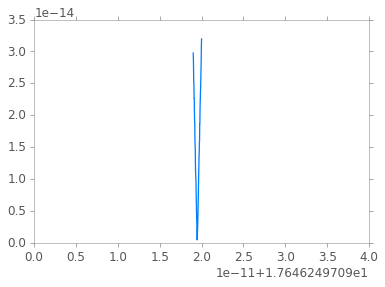

3.1330701123 3.1330701123 72.298177969


In [8]:
# emperically find alpha values for which we get same value of beta 
# Here, I manually found the second alpha by minimized the error visually!

zo=-509.0
f = 24.0
de=-5.0

mp=0.15; alpha=45
#mp=0.1; alpha=15

tBeta0 = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
#alphaArr = np.linspace(33.837970239821, 33.837970239825) # for mp=0.1; alpha=15
alphaArr = np.linspace(17.646249708999, 17.646249709)   # for mp=0.15; alpha=45
#alphaArr = np.linspace(89.0, 90.0)   # for mp=0.15; alpha=45 ; to check if another intersection near 90°
absErr = []
for each in alphaArr:
    tBeta1 = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=each)
    absErr.append(abs(tBeta1 - tBeta0))

absErr = np.array(absErr)

plt.plot(alphaArr, absErr)
plt.show()

print(get_tanBeta(de=de, zo=zo, f=f, mp=0.15, alpha=17.646249709), 
      get_tanBeta(de=de, zo=zo, f=f, mp=0.15, alpha=45.0), 
      get_beta(de=de, zo=zo, f=f, mp=0.15, alpha=45))

#print(get_tanBeta(de=de, zo=zo, f=f, mp=0.1, alpha=15.0), 
#      get_tanBeta(de=de, zo=zo, f=f, mp=0.1, alpha=33.837970239821), 
#      get_beta(de=de, zo=zo, f=f, mp=0.1, alpha=15))

# Emperically found
# for mp=0.15; alpha=17.646249709, 45; tanbeta = 3.1330701123; beta = 72.298177969
# for mp=0.1; alpha=15.0, 33.837970239821; tanbeta = 2.00014403634; beta = 63.4365992627

The following plots demonstrates that for some values of $m_p$ (or perhaps, for certain combination of lens parameters $m_p$, $f$, $d_e$ and object distance $z_o$), the plot of $g(\alpha, m_p, d_e, f, z_o)$ (and therefore $\beta$) is not monotonic for increasing values of $\alpha$. 

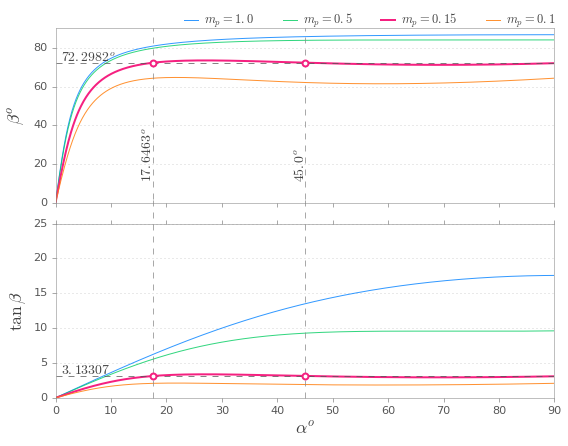

In [9]:
# plot of alpha vs. beta 
FIGURE_FOR_WORD = False

# this plot shows that given alpha, we MAY NOT get a unique beta within +/-90°
zo = -509.0
f = 24.0
de = -5.0

if FIGURE_FOR_WORD:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    tsf = 1.25

alpha = np.linspace(0., 89.99999, 1000)
cols = ['#0080FF', '#00CC60', '#F52080', '#ff7f0e',]
alps = [0.8, 0.8, 1.0, 0.85]
lws = [1., 1., 2.0, 1.]
for i, mp in enumerate([1.0, 0.5, 0.15, 0.1]):
    beta = get_beta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
    tBeta = get_tanBeta(de=de, zo=zo, f=f, mp=mp, alpha=alpha)
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, beta, color=cols[i], alpha=alps[i], lw=lws[i], label=legTxt)
    ax1.plot(alpha, tBeta, color=cols[i], alpha=alps[i], lw=lws[i], label=legTxt)
    
ax0.scatter([17.646249709, 45], [72.298177969, 72.298177969], s=35, 
            edgecolor='#F52080', color='w', lw=2., zorder=10)
ax1.scatter([17.646249709, 45], [3.1330701123, 3.1330701123], s=35, 
            edgecolor='#F52080', color='w', lw=2., zorder=10)

# plot the non-unique alpha, beta points for illustration
# These values were emperically found
# for mp=0.15; alpha=17.646249709, 45; tanbeta = 3.1330701123; beta = 72.298177969
ax0.axhline(72.298177969, color='#555555', alpha=0.9, lw=0.8, linestyle='dashed')
ax1.axhline(3.1330701123, color='#555555', alpha=0.9, lw=0.8, linestyle='dashed')

ax0.axvline(17.646249709, ymin=0.02, color='#888888', alpha=0.9, lw=0.8, linestyle='dashed')
ax0.axvline(45.0, ymin=0.02, color='#888888', alpha=0.9, lw=0.8, linestyle='dashed')
ax1.axvline(x=17.646249709, ymin=0, ymax=1.15, color='#888888', alpha=0.9, lw=0.8, 
            linestyle='dashed', clip_on=False)
ax1.axvline(x=45.0, ymin=0, ymax=1.15, color='#888888', alpha=0.9, lw=0.8, 
            linestyle='dashed', clip_on=False)
# for mp=0.1; alpha=15.0, 33.837970239821; tanbeta = 2.00014403634; beta = 63.4365992627
#ax0.axhline(63.4365992627)
#ax1.axhline(2.00014403634)

# figure decorations
for ax in [ax0, ax1]:
    ax.grid(axis='y', alpha=0.45)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))    # number of ticks
    ax.yaxis.set_ticks_position('left')                # tick
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)

# set limits
ax0.set_ylim(0, 90); ax1.set_ylim(0, 25)
ax0.set_xlim(0, 90); ax1.set_xlim(0, 90)

# Text to indicate angles
ax0.text(1, 72.7,  r'$72.2982^o$', fontsize=11*tsf)
ax1.text(1, 3.4, r'$3.13307$', fontsize=11*tsf)
ax0.text(15.5, 11,  r'$17.6463^o$', rotation='vertical', va='bottom', fontsize=11*tsf)
ax0.text(42.8, 11,  r'$45.0^o$', rotation='vertical', va='bottom', fontsize=11*tsf)

ax0.xaxis.set_ticks_position('bottom')
ax1.set_xlabel(r'$\alpha^o$', fontsize=14*tsf)
ax0.set_ylabel(r'$\beta^o$', fontsize=14*tsf)
ax1.set_ylabel(r'$\rm{tan}\, \beta$', fontsize=14*tsf)
# legend
#ax.legend(loc=(0.01, 0.8), labelspacing=0.008, fontsize=10*tsf)

ax0.legend(fontsize=10*tsf, ncol=4, loc='lower left', bbox_to_anchor=(0.3, 0.945), 
          bbox_transform=fig.transFigure, handletextpad=0.2, handlelength=1.7)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'alpha_vs_beta_with_mp_lens_tilt_away_from_enpp.png')

plt.show()

So, now we need to answer the following **two questions**:

(1) How can we detect the situation when multiple (probably just two) $\alpha$ for which we get the same $\beta$?

(2) Can we find an algebraic expression (a function of the relevant optical parameters) for the condition?  <font color='red'>[HOW CAN I ANSWER THIS??]</font>

In order to answer (1), we can take the derivative of $g(\alpha, m_p, d_e, f, z_o)$ w.r.t. $\alpha$ and find out if the derivative, $\dot{g}(\alpha, m_p, d_e, f, z_o)$, is always positive (monotonically increasing) or always negative (monotonically decreasing) with an interval $[a, b]$. If $\dot{g}(\alpha, m_p, d_e, f, z_o)$ changes sign within the interval of interest $[a, b]$, then $g(\alpha, m_p, d_e, f, z_o)$ is not monotonic. In other words, if we can find real roots of $\dot{g}(\alpha, m_p, d_e, f, z_o)$, then $g(\alpha, m_p, d_e, f, z_o)$ is not monotonic. 

We will find the derivative using SymPy.

In [10]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a, mp, zo, f, de = sy.symbols('alpha, m_p, z_o, f, d_e', real=True)
numr = -sy.sin(a)*(mp*(zo - de*sy.cos(a)) + f*(1 - mp)*sy.cos(a))
deno = (f - mp*de*sy.sin(a)**2)*(mp*sy.cos(a)**2 + sy.sin(a)**2) + mp*(1-mp)*de*sy.sin(a)**2*sy.cos(a)**2
expr = numr/deno
expr

              -(f⋅(-m_p + 1)⋅cos(α) + m_p⋅(-dₑ⋅cos(α) + zₒ))⋅sin(α)           
──────────────────────────────────────────────────────────────────────────────
                     2       2      ⎛       2         2   ⎞ ⎛            2    
dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p⋅sin (α) 

    
────
   ⎞
+ f⎠

In [11]:
sy.diff(expr, a)

                                                                              
                     (dₑ⋅m_p⋅sin(α) - f⋅(-m_p + 1)⋅sin(α))⋅sin(α)             
- ────────────────────────────────────────────────────────────────────────────
                       2       2      ⎛       2         2   ⎞ ⎛            2  
  dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p⋅sin (α
                                                                              

                                                                              
                        (f⋅(-m_p + 1)⋅cos(α) + m_p⋅(-dₑ⋅cos(α) + zₒ))⋅cos(α)  
────── - ─────────────────────────────────────────────────────────────────────
     ⎞                        2       2      ⎛       2         2   ⎞ ⎛        
) + f⎠   dₑ⋅m_p⋅(-m_p + 1)⋅sin (α)⋅cos (α) + ⎝m_p⋅cos (α) + sin (α)⎠⋅⎝- dₑ⋅m_p
                                                                              

                                                  

Well ... well ... well! That is getting a little too complicated. Let's abandon it for now, and examine the more relevant case of rotating the lens about the ENPP, which we expect to be simpler. If we find a useful strategy, then we can come back and apply the same strategy here.

## Lens rotated about the x-axis at ENPP

If the lens is rotated about the ENPP ($d_e = 0$), the expression for $\tan \,\beta$ (or equivalently the expression for $g(\alpha, m_p, f, z_o)$) reduces to:

$$
tan \,\beta = g(\alpha, m_p, f, z_o) =
- \frac{\sin\,\alpha \left( m_p z_o +  f \left(1 - m_p \right) \cos \,\alpha \right)}{f \left(m_p \cos^2\alpha + \sin^2\alpha \right)}
$$

The image plane distance is given by

$$
\acute{z}_{o} = d \cos\,\alpha + \frac{m_p z_o f (m_p \cos^2\alpha + \sin^2\alpha)}{m_p z_o \cos\,\alpha + f}
$$


In [12]:
def get_zoDash2(zo, f, mp, d, alpha):
    """formula for computing the image plane distance from the pivot 
    (origin of {C}) if lens is tilted about the ENPP. i.e. de=0, deDash=d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: d: distance from ENPP to EXPP
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    
    Note:
    Assuming zo is numerically negative,
     o zoDash is +ve if |zo*mp*c| > f; image is real and inverted
     o zoDash is  ∞  if |zo*mp*c| = f
     o zoDash is -ve if |zo*mp*c| < f
    """
    c = cosd(alpha)
    s = sind(alpha)
    return d*c + mp*f*zo*(mp*c**2 + s**2)/(zo*mp*c + f)

def get_beta2(zo, f, mp, alpha):
    """formula for computing the object plane tilt angle if lens is 
    tilted about the ENPP. That is de=0, deDash=d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return arctand(t)

def get_tanBeta2(zo, f, mp, alpha):
    """
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return t

As before, we will find the derivative of $g(\alpha, m_p, f, z_o)$ using SymPy.

In [13]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a, mp, zo, f, de = sy.symbols('alpha, m_p, z_o, f, d_e', real=True)
numr = -sy.sin(a)*(mp*zo + f*(1 - mp)*sy.cos(a))
deno = f*(mp*sy.cos(a)**2 + sy.sin(a)**2)
expr = numr/deno
expr

-(f⋅(-m_p + 1)⋅cos(α) + m_p⋅zₒ)⋅sin(α) 
───────────────────────────────────────
         ⎛       2         2   ⎞       
       f⋅⎝m_p⋅cos (α) + sin (α)⎠       

In [14]:
firstDeri = sy.diff(expr, a)
firstDeri

                2                                                             
  (-m_p + 1)⋅sin (α)    (f⋅(-m_p + 1)⋅cos(α) + m_p⋅zₒ)⋅cos(α)   (f⋅(-m_p + 1)⋅
───────────────────── - ───────────────────────────────────── - ──────────────
       2         2              ⎛       2         2   ⎞                       
m_p⋅cos (α) + sin (α)         f⋅⎝m_p⋅cos (α) + sin (α)⎠                       
                                                                              

                                                               
cos(α) + m_p⋅zₒ)⋅(2⋅m_p⋅sin(α)⋅cos(α) - 2⋅sin(α)⋅cos(α))⋅sin(α)
───────────────────────────────────────────────────────────────
                                     2                         
              ⎛       2         2   ⎞                          
            f⋅⎝m_p⋅cos (α) + sin (α)⎠                          

In [15]:
firstDeri = sy.simplify(firstDeri)
firstDeri

     2    2                   2             2       3           2             
f⋅m_p ⋅cos (α) - f⋅m_p - f⋅cos (α) + f + m_p ⋅zₒ⋅cos (α) - 2⋅m_p ⋅zₒ⋅cos(α) - 
──────────────────────────────────────────────────────────────────────────────
                                                                  2           
                                           ⎛       2         2   ⎞            
                                         f⋅⎝m_p⋅cos (α) + sin (α)⎠            

          3                   
m_p⋅zₒ⋅cos (α) + m_p⋅zₒ⋅cos(α)
──────────────────────────────
                              
                              
                              

In [16]:
# turn off sympy's pretty printing 
sy.init_printing(pretty_print=False, use_latex=False)

The first derivative $\dot{g}(\alpha, m_p, f, z_o)$ is the following cubic (in $\cos \,\alpha$) equation:

$$
\dot{g}(\alpha, m_p, f, z_o) = \frac{-1}{f \left(m_p \cos^2\alpha + \sin^2\alpha \right)^2 }\, \left[ m_p (1 - m_p) z_o \cos^3\alpha + f(1 - m_p^2) \cos^2\alpha - m_p (1 - 2 m_p) z_o \cos \,\alpha - f(1-m_p) \right]
$$

We can readily examine the case when $m_p=1$:

$$
\dot{g}(\alpha, m_p, f, z_o) = -\frac{z_o}{f} \cos \,\alpha
$$

In the interval $[-\pi/2, \pi/2]$, $\dot{g}(\alpha, m_p, f, z_o)$ is always positive since $z_o$ (directed object distance from the camera frame origin) is numerically negative. Therefore, $g(\alpha, m_p, f, z_o)$ is a monotonically increasing function if $m_p=1$. Also, since $\dot{g}(\alpha, m_p, f, z_o)$ is a monotonically increasing function if $m_p=1$, we expect $\beta$ to increase with increasing $\alpha$.  

Also note that $\,f^{-1} \left(m_p \cos^2\alpha + \sin^2\alpha \right)^{-2} = f^{-1} \left[1 - (1 - m_p) \cos^2\alpha \right]^{-2} > 0$ . Therefore, the derivative is zero only when the cubic term is zero.  

In [17]:
def first_derivative_Falpha(zo, f, mp, alpha):
    """evaluate the first derivative of the g(α, m_p, f, z_o). 
    
    It is assumed that the lens is rotated about the ENPP. Therefore, 
    the first derivative is a cubic equation in cos(α)
    """
    a = -mp*(1 - mp)*zo
    b = -f*(1 - mp**2)
    c = mp*(1 - 2*mp)*zo
    d = f*(1 - mp)
    numr = a*cosd(alpha)**3 + b*cosd(alpha)**2 + c*cosd(alpha) + d
    deno = f*(mp*cosd(alpha)**2 + sind(alpha)**2)**2
    firstDeri = numr/deno
    return firstDeri

def first_derivative_Falpha2(zo, f, mp, x):
    """evaluate the first derivative of the g(α, m_p, f, z_o).
    
    The input to this function is x (0, 1) instead of α
    
    It is assumed that the lens is rotated about the ENPP. Therefore, 
    the first derivative is a cubic equation in cos(α)
    """
    a = -mp*(1 - mp)*zo
    b = -f*(1 - mp**2)
    c = mp*(1 - 2*mp)*zo
    d = f*(1 - mp)
    numr = a*x**3 + b*x**2 + c*x + d
    deno = f*(1.0 - (1.0 - mp)*x**2)**2
    firstDeri = numr/deno
    return firstDeri

def roots_first_derivative_Falpha(zo, f, mp):
    """returns the roots and discriminant of g'(α, m_p, f, z_o)
    
    It is assumed that the lens is rotated about the ENPP. Therefore, 
    the first derivative is a cubic equation in cos(α)
    """
    #a = -mp*(1 - mp)*zo
    #b = -f*(1 - mp**2)
    #c = mp*(1 - 2*mp)*zo
    #d = f*(1 - mp)
    # in the computation of the discriminant we have to compute c**3 which
    # can become very large and cause overflow if the coefficients are used
    # as above. So, we divide all the coefficients by a (if mp ≠ 1)
    if mp == 1.0:
        a, b, c, d = 0, 0, -zo, 0
    else:
        a = 1
        b = f*(1 + mp)/(mp*zo)
        c = -(1 - 2*mp)/(1 - mp)
        d = -f/(mp*zo)
    roots = np.roots([a, b, c, d])
    discriminant = np.float64(0)
    discriminant = (b**2)*(c**2) - 4*a*(c**3) - 4*(b**3)*d - 27*(a**2)*(d**2) + 18*a*b*c*d
    return roots, discriminant

Like before, we will first emperically find cases of multiple $\alpha$ that result in same $\beta$.

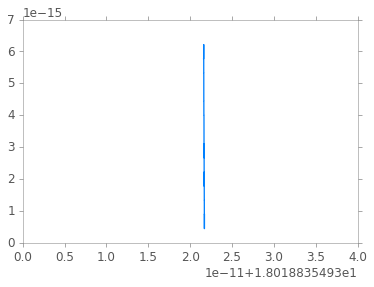

3.17301469156 3.17301469156 72.5073533271


In [18]:
# emperically find alpha s for which we get multiple values of beta 

zo=-509.0
f = 24.0

mp=0.15; alpha=45

tBeta0 = get_tanBeta2(zo=zo, f=f, mp=mp, alpha=45)
alphaArr = np.linspace(18.0188354928516, 18.0188354928517)
absErr = []
for each in alphaArr:
    tBeta1 = get_tanBeta2(zo=zo, f=f, mp=mp, alpha=each)
    absErr.append(abs(tBeta1 - tBeta0))

absErr = np.array(absErr)

plt.plot(alphaArr, absErr)
plt.show()

print(get_tanBeta2(zo=zo, f=f, mp=0.15, alpha=18.0188354928516), 
      get_tanBeta2(zo=zo, f=f, mp=0.15, alpha=45.0), 
      get_beta2(zo=zo, f=f, mp=0.15, alpha=45))

# Emperically found
# for mp=0.15; alpha=18.0188354928516, 45; tanbeta = 3.17301469156; beta = 72.5073533271

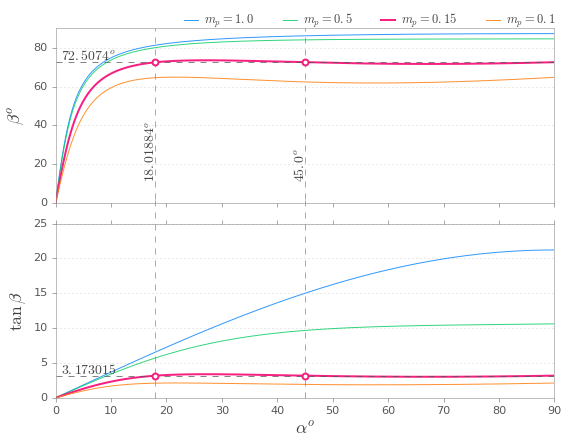

In [19]:
# plot of alpha vs. beta 
FIGURE_FOR_WORD = False

if FIGURE_FOR_WORD:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    tsf = 1.25
#fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))


# this plot shows that given alpha, we MAY NOT get a unique beta within +/-90°
zo=-509.0
f = 24.0

alpha = np.linspace(0., 89.99999, 1000)
cols = ['#0080FF', '#00CC60', '#F52080', '#ff7f0e',]
alps = [0.8, 0.8, 1.0, 0.85]
lws = [1., 1., 2.0, 1.]
for i, mp in enumerate([1.0, 0.5, 0.15, 0.1]):
    beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alpha)
    tBeta = get_tanBeta2(zo=zo, f=f, mp=mp, alpha=alpha)
    legTxt = r'$m_p={}$'.format(mp)
    ax0.plot(alpha, beta, color=cols[i], alpha=alps[i], lw=lws[i], label=legTxt)
    ax1.plot(alpha, tBeta, color=cols[i], alpha=alps[i], lw=lws[i], label=legTxt)
    
ax0.scatter([18.0188354928516, 45], [72.5073533271, 72.5073533271], s=35, 
            edgecolor='#F52080', color='w', lw=2., zorder=10)
ax1.scatter([18.0188354928516, 45], [3.17301469156, 3.17301469156], s=35, 
            edgecolor='#F52080', color='w', lw=2., zorder=10)
    
# plot the non-unique alpha, beta points for illustration
# These values were emperically found
# for mp=0.15; alpha=18.0188354928516, 45; tanbeta = 3.17301469156; beta = 72.5073533271
ax0.axhline(72.5073533271, color='#555555', alpha=0.9, lw=0.8, linestyle='dashed')
ax1.axhline(3.17301469156, color='#555555', alpha=0.9, lw=0.8, linestyle='dashed')

ax0.axvline(18.0188354928516, ymin=0.02, color='#888888', alpha=0.9, lw=0.8, linestyle='dashed')
ax0.axvline(45.0, ymin=0.02, color='#888888', alpha=0.9, lw=0.8, linestyle='dashed')
ax1.axvline(x=18.0188354928516, ymin=0, ymax=1.15, color='#888888', alpha=0.9, lw=0.8, 
            linestyle='dashed', clip_on=False)
ax1.axvline(x=45.0, ymin=0, ymax=1.15, color='#888888', alpha=0.9, lw=0.8, 
            linestyle='dashed', clip_on=False)
#ax2.axhline(color='#555555', alpha=0.8, lw=1.2, linestyle='dashed')

# plot decorations
#ax2.set_ylim(-1.5, 21)
for ax in [ax0, ax1, ax2]:
    ax.grid(axis='y', alpha=0.45)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))    # number of ticks
    ax.yaxis.set_ticks_position('left')               # tick
    # ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)

# set limits
ax0.set_ylim(0, 90); ax1.set_ylim(0, 25)
ax0.set_xlim(0, 90); ax1.set_xlim(0, 90)
        
# Text to indicate angles
ax0.text(1, 73.5,  r'$72.5074^o$', fontsize=11*tsf)
ax1.text(1, 3.36, r'$3.173015$', fontsize=11*tsf)
ax0.text(15.9, 11,  r'$18.01884^o$', rotation='vertical', va='bottom', fontsize=11*tsf)
ax0.text(42.8, 11,  r'$45.0^o$', rotation='vertical', va='bottom', fontsize=11*tsf)

#ax.legend(loc=(0.01, 0.8), labelspacing=0.008, fontsize=14)
ax0.xaxis.set_ticks_position('bottom')
ax1.set_xlabel(r'$\alpha^o$', fontsize=14*tsf)
ax0.set_ylabel(r'$\beta^o$', fontsize=14*tsf)
ax1.set_ylabel(r'$\rm{tan}\, \beta$', fontsize=14*tsf)
#ax2.set_ylabel(r'$d/dx \, [F(\alpha)]$')

ax0.legend(fontsize=10*tsf, ncol=4, loc='lower left', bbox_to_anchor=(0.3, 0.945), 
           bbox_transform=fig.transFigure, handletextpad=0.2, handlelength=1.7)

fig.tight_layout()

# Save the figure  
#saveFigure(fig, 'alpha_vs_beta_with_mp_lens_tilt_about_enpp.png')

plt.show()

### Examination of the first derivative $\dot{g}(\alpha, m_p, f, z_o)$ and its roots

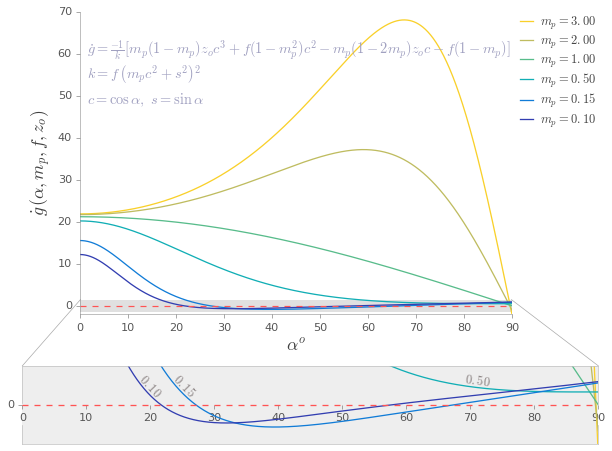

In [20]:
# plot of the first derivative (This plot is to be discarded although I really like it!)
FIGURE_FOR_WORD = False

zo=-509.0
f = 24.0

if FIGURE_FOR_WORD:
    fig = plt.figure(figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig = plt.figure(figsize=(8, 6))
    tsf = 1.25

ax0 = fig.add_axes([0.1, 0.3, 0.75, 0.7])  # [*left*, *bottom*, *width*, *height*]
ax1 = fig.add_axes([0.0, 0.0, 1.0, 0.18,])

cols = ['#F9D02A', '#BFBC60', '#58BC8B', '#11AEB5', '#117CD7', '#323EB1', ]

alpha = np.linspace(0., 89.9999, 1000)

#for i, mp in enumerate([5.0, 3.0, 2.0, 1.0, 0.5, 0.374, 0.37, 0.15, 0.1, 0.05]):
for i, mp in enumerate([3.0, 2.0, 1.0, 0.5, 0.15, 0.1]):
    legTxt = r'$m_p={:0.2f}$'.format(mp)
    ax0.plot(alpha, first_derivative_Falpha(zo, f, mp, alpha), color=cols[i], label=legTxt)
    ax1.plot(alpha, first_derivative_Falpha(zo, f, mp, alpha), color=cols[i])
    #ax0.plot(cosd(alpha), first_derivative_Falpha(zo, f, mp, alpha), color=cols[i], label=legTxt)
    #ax1.plot(cosd(alpha), first_derivative_Falpha(zo, f, mp, alpha), color=cols[i])

# ticks
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))
#ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_ticks_position('bottom') 
ax1.xaxis.set_tick_params(direction='out')
ax1.spines['bottom'].set_position(('data',0))
ax1.spines['right'].set_color('none')
ax1.spines['left'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')
for ax in [ax0, ax1]:
    ax.yaxis.set_ticks_position('left')              
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)

# plot the case of mp=1 separately to verify
# ax0.plot(alpha, -(zo/f)*cosd(alpha), 'b', linestyle='dashed') # It does overlap

ax0.axhline(color='#FF5353', alpha=1, lw=1.2, linestyle='dashed')
ax1.axhline(color='#FF5353', alpha=1, lw=1.3, linestyle='dashed')

#ax0.set_ylabel(r'$d/dx \, [F\,(\alpha, m_p, f, z_o)]$', fontsize=14*tsf)
ax0.set_ylabel(r"$\dot{g}\,(\alpha, m_p, f, z_o)$", fontsize=14*tsf)
ax0.set_xlabel(r'$\alpha^o$', fontsize=14*tsf)

# insets
# create rect patch for the inset
inset_dst_rect = patches.Rectangle((0.1, -1.5), 89.9, 3, fill=True, facecolor='#E0E0E0',
                                   edgecolor='none', zorder=2, lw=1.1)
ax0.add_patch(inset_dst_rect)
ax1.set_axis_bgcolor('#EEEEEE')

# manual connection of the inset
ax0.set_xlim(0, 90)
ax1.set_xlim(0, 90)
ax0.set_ylim(-2, 70)
ax1.set_ylim(-1.5, 1.5)
ax0.plot([0.1, -12], [1.47, -14.3], lw=0.7, color='#AAAAAA', clip_on=False)
ax0.plot([89.9, 108], [1.47, -14.3], lw=0.7, color='#AAAAAA', clip_on=False)
ax1.axhline(y=-1.5, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axhline(y=1.5, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=0, ymin=0.52, ymax=1, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=0, ymin=0.24, ymax=0.0, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=90, ymin=0.5, ymax=1, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=90, ymin=0.24, ymax=0.0, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)

# Inset text
ax1.text(17.75, 0.85, r'$0.10$', rotation=-47, fontsize=10*tsf, color='#888080',)
ax1.text(23.05, 0.85, r'$0.15$', rotation=-46, fontsize=10*tsf, color='#888080',)
ax1.text(69., 0.85, r'$0.50$', rotation=-8, fontsize=10*tsf, color='#888080',)

# Equation text
et1 = (r"$\dot{g} = \frac{-1}{k} [m_p (1 - m_p) z_o c^3 +"
       "f(1 - m_p^2) c^2 - m_p (1 - 2 m_p) z_o c - f(1-m_p)]$")
et2 = r"$k = f \, \left(m_p c^2 + s^2 \right)^2$"
et3 = r"$c = \cos \,\alpha , \,\, s = \sin \,\alpha$"

ax0.text(1.5, 60, et1, fontsize=11.5*tsf, color='#A0A0C0', zorder=2)
ax0.text(1.5, 54, et2, fontsize=11.5*tsf, color='#A0A0C0', zorder=2)
ax0.text(1.5, 48, et3, fontsize=11.5*tsf, color='#A0A0C0', zorder=2)

# legend
ax0.legend(fontsize=10*tsf, ncol=1, loc='upper right', bbox_to_anchor=(1.015, 1.02), 
           bbox_transform=fig.transFigure, labelspacing=0.17, handletextpad=0.2, handlelength=1.7)

# Save the figure  
#saveFigure(fig, 'first_derivative_falpha_about_enpp.png')

plt.show()

Alternate (and the more appropriate) plot of the first derivative (the x-axis represents $\cos \alpha$)

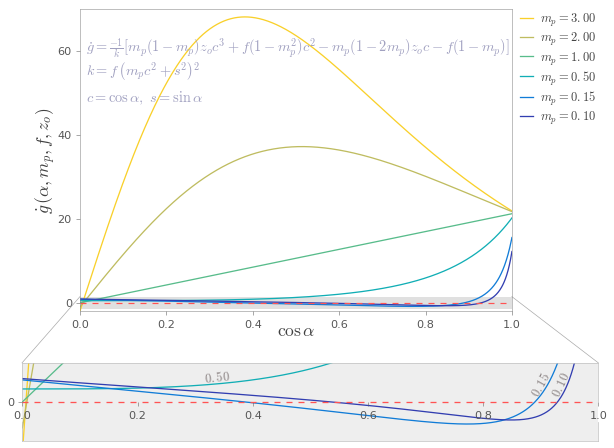

In [21]:
# plot of the first derivative
FIGURE_FOR_WORD = False

zo=-509.0
f = 24.0

if FIGURE_FOR_WORD:
    fig = plt.figure(figsize=(6.4, 4.8))
    tsf = 1.0  # text scale factor
else:
    fig = plt.figure(figsize=(8, 6))
    tsf = 1.25

ax0 = fig.add_axes([0.1, 0.3, 0.75, 0.7])  # [*left*, *bottom*, *width*, *height*]
ax1 = fig.add_axes([0.0, 0.0, 1.0, 0.18,])

cols = ['#F9D02A', '#BFBC60', '#58BC8B', '#11AEB5', '#117CD7', '#323EB1', ]

x = np.linspace(0., 1.0, 1000)

for i, mp in enumerate([3.0, 2.0, 1.0, 0.5, 0.15, 0.1]):
    legTxt = r'$m_p={:0.2f}$'.format(mp)
    ax0.plot(x, first_derivative_Falpha2(zo, f, mp, x), color=cols[i], label=legTxt)
    ax1.plot(x, first_derivative_Falpha2(zo, f, mp, x), color=cols[i], zorder=0)

# ticks
#ax0.spines['right'].set_visible(False)
#ax0.spines['top'].set_visible(False)
ax0.xaxis.set_ticks_position('bottom')
ax0.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))
#ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_ticks_position('bottom') 
ax1.xaxis.set_tick_params(direction='out')
ax1.spines['bottom'].set_position(('data',0))
ax1.spines['right'].set_color('none')
ax1.spines['left'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')
for ax in [ax0, ax1]:
    ax.yaxis.set_ticks_position('left')              
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9*tsf)
        
ax0.axhline(color='#FF5353', alpha=1, lw=1.2, linestyle='dashed')
ax1.axhline(color='#FF5353', alpha=1, lw=1.3, linestyle='dashed')

ax0.set_ylabel(r"$\dot{g}\,(\alpha, m_p, f, z_o)$", fontsize=14*tsf, labelpad=-0.5)
ax0.set_xlabel(r'$\cos \,\alpha$', fontsize=14*tsf, labelpad=-7.5)

# insets
# create rect patch for the inset
inset_dst_rect = patches.Rectangle((0.0001, -1.5), 0.99999, 3, fill=True, facecolor='#E0E0E0',
                                   edgecolor='none', zorder=2, lw=1.1)
ax0.add_patch(inset_dst_rect)
ax1.set_axis_bgcolor('#EEEEEE')

# manual connection of the inset
ax0.set_xlim(0, 1.0)
ax1.set_xlim(0, 1.0)
ax0.set_ylim(-2, 70)
ax1.set_ylim(-1.5, 1.5)
ax0.plot([0.0001, -0.134], [1.47, -14.3], lw=0.7, color='#AAAAAA', clip_on=False)
ax0.plot([0.9999, 1.2], [1.47, -14.3], lw=0.7, color='#AAAAAA', clip_on=False)
ax1.axhline(y=-1.5, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axhline(y=1.5, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=0, ymin=0.52, ymax=1, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=0, ymin=0.24, ymax=0.0, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=1, ymin=0.5, ymax=1, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)
ax1.axvline(x=1, ymin=0.24, ymax=0.0, lw=0.7, color='#C0C0C0', zorder=12, clip_on=False)

# Inset text
ax1.text(0.916, 0.85, r'$0.10$', rotation=65, fontsize=10*tsf, color='#888080',)
ax1.text(0.8795, 0.85, r'$0.15$', rotation=61, fontsize=10*tsf, color='#888080',)
ax1.text(0.315, 0.85, r'$0.50$', rotation=6, fontsize=10*tsf, color='#888080',)

# Equation text
et1 = (r"$\dot{g} = \frac{-1}{k} [m_p (1 - m_p) z_o c^3 +"
       "f(1 - m_p^2) c^2 - m_p (1 - 2 m_p) z_o c - f(1-m_p)]$")
et2 = r"$k = f \, \left(m_p c^2 + s^2 \right)^2$"
et3 = r"$c = \cos \,\alpha , \,\, s = \sin \,\alpha$"

ax0.text(0.015, 60, et1, fontsize=11.5*tsf, color='#A0A0C0', zorder=2)
ax0.text(0.015, 54, et2, fontsize=11.5*tsf, color='#A0A0C0', zorder=2)
ax0.text(0.015, 48, et3, fontsize=11.5*tsf, color='#A0A0C0', zorder=2)

# legend
ax0.legend(fontsize=10*tsf, ncol=1, loc='upper right', bbox_to_anchor=(1.015, 1.02), 
           bbox_transform=fig.transFigure, labelspacing=0.17, handletextpad=0.2, handlelength=1.7)

# Save the figure  
#saveFigure(fig, 'first_derivative_falpha_about_enpp.png')

plt.show()

In [22]:
# We only care about real and positive roots between 0 and 1 
# because 0 < cos(α) < 1  for -π/2 < α < π/2

# in the function we set the upper angle threshold to cos(89.5°) = 0.0087265

# note np.isreal(-0.00654822+0.j ) returns True

def first_derivative_has_real_positive_roots(zo, f, mp, x0=0.0087265, x1=1.0):
    """returns True if the first derivative of the function g(α, m_p, f, z_o) have real roots 
    within the valid range of angles     
    
    If the function returns True, then g(α, m_p, f, z_o) is NOT a monotonically increasing/decreasing 
    function and hence we there are two α for the same value of β
    """
    roots, disc = roots_first_derivative_Falpha(zo, f, mp)
    roots = np.array([np.real(root) for root in roots if np.isreal(root)])
    return np.any(np.logical_and((roots >= x0), (roots <= x1)))

Nature of roots of cubic equations (from [Wikipedia](https://en.wikipedia.org/wiki/Cubic_function)):

Let $\Delta$ represent the discriminant. Then

* if $\Delta > 0$, then the equation has three distinct real roots.
* if $\Delta = 0$, then the equation has a multiple root and all its roots are real.
* if $\Delta < 0$, then the equation has one real root and two non-real complex conjugate roots.

Therefore, **there is always at least one real root of a cubic equation**.

In our particular problem, however, we only care about positive real roots in $(0,1)$.

In [23]:
zo=-509.0
f = 24.0
for mp in [10.0, 5.0, 3.0, 2.0, 1.1, 1.0, 0.9, 0.7, 0.5, 0.3735, 0.37, 0.15, 0.1]:
    print('---------------------------------------------------------------')
    print('mp =', mp)
    roots, disc = roots_first_derivative_Falpha(zo, f, mp)
    print('Roots of first derivative =', roots)
    print('Discrimiant of first derivative =', disc)
    roots = np.array([np.real(root) for root in roots if np.isreal(root)])
    print('Real positive and negative roots =', roots)
    print('Real positive roots in (0, cosd(89.5)):', first_derivative_has_real_positive_roots(zo, f, mp))

---------------------------------------------------------------
mp = 10.0
Roots of first derivative = [ 1.47803289 -1.42839985  0.00223336]
Discrimiant of first derivative = 37.6558014273
Real positive and negative roots = [ 1.47803289 -1.42839985  0.00223336]
Real positive roots in (0, cosd(89.5)): False
---------------------------------------------------------------
mp = 5.0
Roots of first derivative = [ 1.52649725 -1.47410653  0.00419082]
Discrimiant of first derivative = 45.5979230927
Real positive and negative roots = [ 1.52649725 -1.47410653  0.00419082]
Real positive roots in (0, cosd(89.5)): False
---------------------------------------------------------------
mp = 3.0
Roots of first derivative = [ 1.60979558 -1.55321315  0.00628594]
Discrimiant of first derivative = 62.5625134506
Real positive and negative roots = [ 1.60979558 -1.55321315  0.00628594]
Real positive roots in (0, cosd(89.5)): False
---------------------------------------------------------------
mp = 2.0
Roots of

**Observations:**


1. for $m_p$ very small (how small??) e.g. 0.1, 0.15, and 0.37, we get 3 real roots of which two roots are between 0 and 1. This implies that there are two $\alpha$ for the same $\beta$.
2. for $m_p < 1$ but for which $g(...)$ is monotonic we get 2 imaginary roots and 1 real root. But the real root is negative. Therefore we can discard the real root because $\cos\,\alpha$ is positive for $-\pi/2 < \alpha <\pi/2$. Consequently the first derivative doesn't change sign within the domain of interest and $g(...)$ is monotonic.
3. for $m_p=1$, the first derivative is not a cubic function, but a line passing through the origin. Therefore, the only root is at 0. Consequently the first derivative doesn't chage sign within the domain of interest and $g(...)$ is monotonic.
4. for $m_p > 1$, all three roots are real; however all the roots are outside our interval of interest.

Question: Is there any pattern for the coefficients?

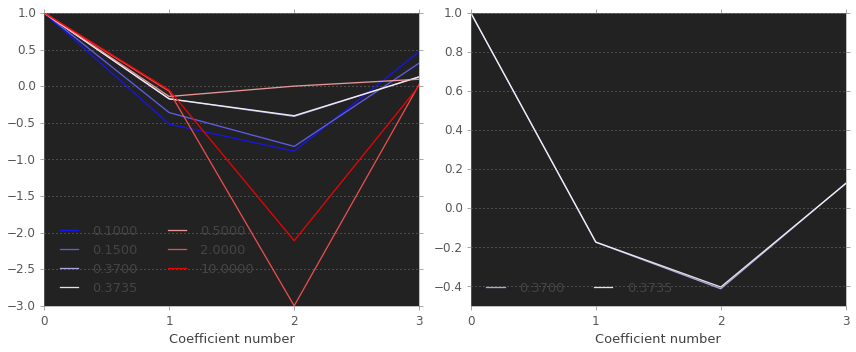

In [24]:
zo=-509.0
f = 24.0

mpArr = [0.1, 0.15, 0.37, 0.3735, 0.5, 2.0, 10.0]

# generate discrete sequential colormap
n = len(mpArr)
sta, end = 10, 255
ci = [int(sta + (end - sta)*float(i)/(n-1)) for i in range(n)]
colArr = []
colmap = plt.cm.bwr
for i in ci:
    colArr.append(colmap(i))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

for i, mp in enumerate(mpArr):
    a = 1
    b = f*(1 + mp)/(mp*zo)
    c = -(1 - 2*mp)/(1 - mp)
    d = -f/(mp*zo)
    ax0.plot([0, 1, 2, 3], [a, b, c, d], color=colArr[i], alpha=0.9, label='{:0.4f}'.format(mp))
    if mp in [0.37, 0.3735,]:
        ax1.plot([0, 1, 2, 3], [a, b, c, d], color=colArr[i], alpha=0.9, label='{:0.4f}'.format(mp))

ax1.set_ylim(-0.5, 1.0)
    
for ax in [ax0, ax1]:
    ax.grid(axis='y', color='#AAAAAA')   
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_axis_bgcolor('#222222')
    ax.legend(ncol=2, loc='lower left',)
    ax.set_xlabel('Coefficient number')
    
fig.tight_layout()

plt.show()

From the above plots, it seems that it is hard to find any specific distinguishing feature about the coefficients of the cubic function that may help us to predict the nature of the roots. 
For example, there is nothing in particular that distinguished between the two plots on the right although for $m_p=0.37$ the roots are all real (=> $g(...)$ is non-monotonic while for $m_p=0.3735$ we get two imaginary roots and one real negative root (=> $g(...)$ is monotonic).


So, may be, we just check if the roots are all imginary if $mp < 1$?

###### Exploratory plots to see the nature of the (scaled by a constant) first derivative curve

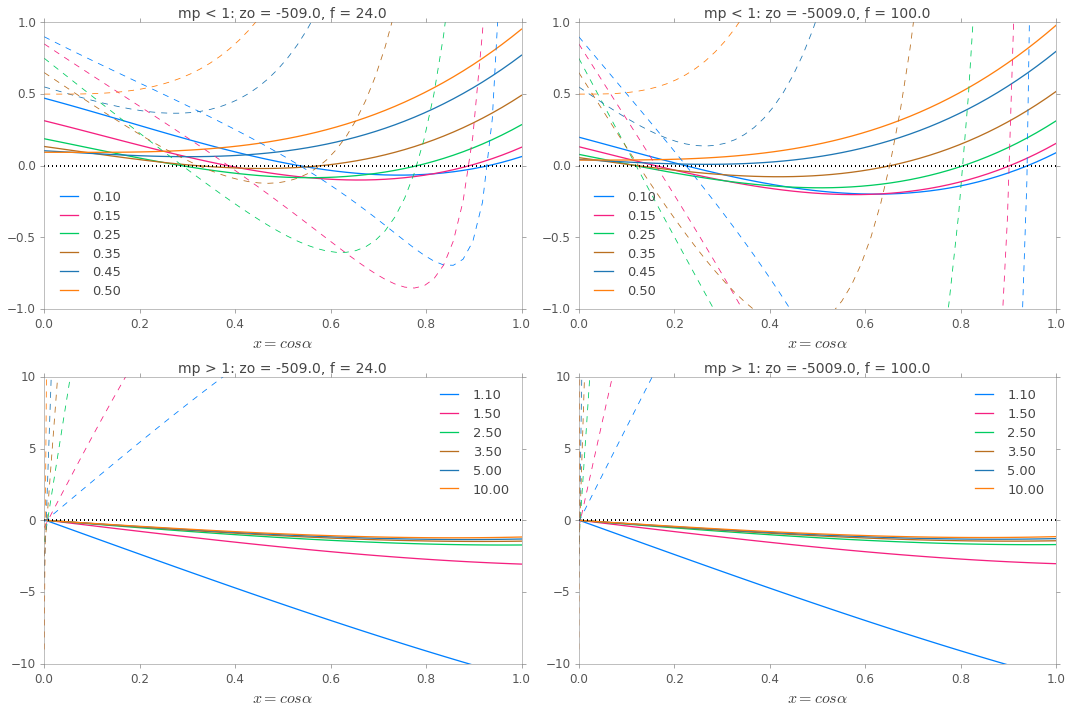

In [166]:
from cycler import cycler

f = [24.0, 100.0]
zo = [-509.0, -5009.0]

def fdir(zo, f, mp, x, scaled=True):
    if scaled:
        a = 1
        b = f*(1 + mp)/(mp*zo)
        c = -(1 - 2*mp)/(1 - mp)
        d = -f/(mp*zo)
        y = a*x**3 + b*x**2 + c*x + d
    else:
        a = -mp*(1 - mp)*zo
        b = -f*(1 - mp**2)
        c = mp*(1 - 2*mp)*zo
        d = f*(1 - mp)
        numr = a*x**3 + b*x**2 + c*x + d
        deno = f*(1.0 - (1.0 - mp)*x**2)**2
        y = numr/deno
    return y 
    
x = np.linspace(0, 1)

# don't use mp=1 in the plot, as the curve is not cubic for mp=1
mpArr0 = [0.1, 0.15, 0.25, 0.35, 0.45, 0.5,]
mpArr1 = [1.1, 1.5, 2.5, 3.5, 5.0, 10.0]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
(ax0, ax1, ax2, ax3) = axes.flatten()

def recycle_axes_color(axes):
    for ax in axes:
        ax.set_prop_cycle(cycler('color', 
                                 ['#0080FF', '#F52080', '#00CC60', 
                                  '#B96F20', '#1f77b4', '#ff7f0e', 
                                  '#2ca02c', '#8c564b', '#00BFFF', 
                                  '#FF8073',])) 

# Plot the scaled coefficients first
scaled = True 
for mp in mpArr0: # mp < 1
    ax0.plot(x, fdir(zo[0], f[0], mp, x, scaled), label='{:0.2f}'.format(mp))
    ax1.plot(x, fdir(zo[1], f[1], mp, x, scaled), label='{:0.2f}'.format(mp))
    ax0.set_title('mp < 1: zo = {}, f = {}'.format(zo[0], f[0]))
    ax1.set_title('mp < 1: zo = {}, f = {}'.format(zo[1], f[1]))
    
for mp in mpArr1: # mp > 1
    ax2.plot(x, fdir(zo[0], f[0], mp, x, scaled), label='{:0.2f}'.format(mp))
    ax3.plot(x, fdir(zo[1], f[1], mp, x, scaled), label='{:0.2f}'.format(mp))
    ax2.set_title('mp > 1: zo = {}, f = {}'.format(zo[0], f[0]))
    ax3.set_title('mp > 1: zo = {}, f = {}'.format(zo[1], f[1]))
    
# Operlapp the unscaled plots to ensure that both have the same zero-crossings
scaled = False 
recycle_axes_color([ax0, ax1, ax2, ax3])

for mp in mpArr0: # mp < 1
    ax0.plot(x, fdir(zo[0], f[0], mp, x, scaled), lw=0.8, linestyle='dashed')
    ax1.plot(x, fdir(zo[1], f[1], mp, x, scaled), lw=0.8, linestyle='dashed')
    
for mp in mpArr1: # mp > 1
    ax2.plot(x, fdir(zo[0], f[0], mp, x, scaled), lw=0.8, linestyle='dashed')
    ax3.plot(x, fdir(zo[1], f[1], mp, x, scaled), lw=0.8, linestyle='dashed')
    
ax0.set_ylim(-1.0, 1.0); ax1.set_ylim(-1.0, 1.0)
ax2.set_ylim(-10, 10); ax3.set_ylim(-10, 10)


for ax in [ax0, ax1, ax2, ax3]:
    ax.axhline(color='k', alpha=1, lw=2, linestyle='dotted')
    ax.set_xlabel(r'$x = cos \alpha$', fontsize=16)

ax0.legend(loc='lower left'); ax1.legend(loc='lower left')
ax2.legend(loc='upper right'); ax3.legend(loc='upper right')

fig.tight_layout()
    
plt.show()

From the above plots we can conclude that the first derivative plots does not cross the x-axis in the interval $(0, 1)$ if $mp > 1$ [Note, they do cross the x-axis very close to zero for large values of $m_p$].

In [25]:

cube_root_real = lambda x: np.sign(x)*np.emath.power(np.abs(x), 1./3)

def cube_root(z):
    """return all three solutions of the cube root of z 
    
    Notes
    -----
    "The cube root of a value, regardless of sign, is a multi-valued function. 
    That means, for any input value, there will be three solutions." [1]
    
    The function `cube_root_real(z)` returns cube root of `z` if `z` is real.
    The `numpy.emath` function `np.emath.power(z)` returns complex root if `z` 
    is complex.
    If z is real, then the real root amongst the three is called the principal root.
    
    References
    ----------
    1. stackoverflow.com/questions/1361740/cubic-root-of-the-negative-number-on-python 
       (answer by Andrew Walker)
    2. en.wikipedia.org/wiki/De_Moivre%27s_formula
    3. en.wikipedia.org/wiki/Cube_root
    """
    z = complex(z)
    x = z.real
    y = z.imag
    mag = abs(z)
    arg =np.arctan2(y, x)
    return [ mag**(1./3) * np.exp( 1j*(arg + 2*n*np.pi)/3 ) for n in range(1,4) ]

def deconstruct_cubic_equation_roots(a, b, c, d, v=False):
    """a, b, c, d are the coefficients of the cubic equation ax³ + bx² + cx + d = 0
    @param: v: (boolean) verbose
    """
    #print('a = ', a, ' b = ', b, ' c = ', c, ' d = ', d)
    Q = c/(3.0*a) - b**2/(9.0*a**2)
    print('Q = ', Q) if v else ''
    R = -b**3/(27.0*a**3) + b*c/(6.0*a**2) - d/(2.0*a)
    print('R = ', R) if v else ''
    D = Q**3 + R**2
    print('D = ', D) if v else ''
    k1 = R + np.emath.sqrt(D)
    k2 = R - np.emath.sqrt(D)
    print('R + sqrt(D) = ', k1) if v else ''
    print('R - sqrt(D) = ', k2) if v else ''
    if np.iscomplex(k1) or np.iscomplex(k2):  
        S = np.emath.power(k1, 1.0/3) 
        T = np.emath.power(k2, 1.0/3)
    else:
        S = cube_root_real(k1)
        T = cube_root_real(k2)
    print('S = ', S) if v else ''
    print('T = ', T) if v else ''
    r1 = -b/(3*a) + S + T
    r2 = -b/(3*a) - (S + T)/2 + (3**0.5)*(S - T)*1j/2
    r3 = -b/(3*a) - (S + T)/2 - (3**0.5)*(S - T)*1j/2
    r1 = r1.real if np.isreal(r1) else r1
    r2 = r2.real if np.isreal(r2) else r2
    r3 = r3.real if np.isreal(r3) else r3
    return [r1, r2, r3]

In [26]:
# Test function against Numpy
a, b, c, d= 1, 3, -144, -432
roots_numpy = np.roots([a, b, c, d])
roots_dcr = deconstruct_cubic_equation_roots(a, b, c, d, True)
print('roots @ numpy = ', roots_numpy)
print('roots @ dcr = ', roots_dcr)

Q =  -49.0
R =  143.0
D =  -97200.0
R + sqrt(D) =  (143+311.769145362j)
R - sqrt(D) =  (143-311.769145362j)
S =  (6.5+2.59807621135j)
T =  (6.5-2.59807621135j)
roots @ numpy =  [ 12. -12.  -3.]
roots @ dcr =  [12.000000000000002, -12.000000000000002, -3.0]


In [122]:
zo=-509.0
f = 24.0

for mp in [5.0, 2.0, 1.1, 0.9, 0.7, 0.5,0.3735, 0.373450599, 0.37, 0.15, 0.1]:
    print('------------------------------------------')
    print('mp = ', mp)
    #a = mp*(1 - mp)*zo
    #b = f*(1 - mp**2)
    #c = -mp*(1 - 2*mp)*zo
    #d = -f*(1 - mp)
    a = 1
    b = f*(1 + mp)/(mp*zo)
    c = -(1 - 2*mp)/(1 - mp)
    d = -f/(mp*zo)
    roots_dcr = deconstruct_cubic_equation_roots(a, b, c, d, True)
    print('roots = ', roots_dcr)

------------------------------------------
mp =  5.0
Q =  -0.750355718868
R =  0.0165096559944
D =  -0.422202991599
R + sqrt(D) =  (0.0165096559944+0.649771491833j)
R - sqrt(D) =  (0.0165096559944-0.649771491833j)
S =  (0.753818368033+0.426747685271j)
T =  (0.753818368033-0.426747685271j)
roots =  [1.5264972468710778, -1.4741065301292169, 0.0041908156746418568]
------------------------------------------
mp =  2.0
Q =  -1.00055581073
R =  0.0235887420997
D =  -1.00111193039
R + sqrt(D) =  (0.0235887420997+1.00055581073j)
R - sqrt(D) =  (0.0235887420997-1.00055581073j)
S =  (0.870168901146+0.493317234859j)
T =  (0.870168901146-0.493317234859j)
roots =  [1.7639134407990764, -1.701043777664867, 0.0078572523864194332]
------------------------------------------
mp =  1.1
Q =  -4.00090032151
R =  0.158626764425
D =  -64.01806271
R + sqrt(D) =  (0.158626764425+8.00112883973j)
R - sqrt(D) =  (0.158626764425-8.00112883973j)
S =  (1.73881625213+0.988644710118j)
T =  (1.73881625213-0.988644710118j

When all the roots are real, then $R + \sqrt{D}$ and $R - \sqrt{D}$ are complex conjugates of each other. Also, $S$ and $T$ are complex conjugates of each other. Also, $D$ is negative when all roots are real.

In [28]:
sy.init_printing(pretty_print=True, use_latex='mathjax')
a1, a2, a0 = sy.symbols('a_1, a_2, a_3', real=True)
mp, zo, f, de = sy.symbols('m_p, z_o, f, d_e', real=True)

In [29]:
expr = (a1/3 - (a2/3)**2)**3 + (a2*a1/6 - a0/2 - (a2/3)**3)**2
expr

          3                     2
⎛       2⎞    ⎛          3     ⎞ 
⎜a₁   a₂ ⎟    ⎜a₁⋅a₂   a₂    a₃⎟ 
⎜── - ───⎟  + ⎜───── - ─── - ──⎟ 
⎝3     9 ⎠    ⎝  6      27   2 ⎠ 

In [30]:
expr = sy.expand(expr)
expr

  3     2   2                3        2
a₁    a₁ ⋅a₂    a₁⋅a₂⋅a₃   a₂ ⋅a₃   a₃ 
─── - ─────── - ──────── + ────── + ───
 27     108        6         27      4 

In [31]:
expr = expr.subs({a2:f*(1+mp)/(mp*zo), a1:-(1-2*mp)/(1-mp), a0:-f/(mp*zo)})
expr

   4          3        2        2                          2          2       
  f ⋅(m_p + 1)        f        f ⋅(m_p + 1)⋅(2⋅m_p - 1)   f ⋅(m_p + 1) ⋅(2⋅m_p
- ───────────── + ────────── + ──────────────────────── - ────────────────────
         4   4         2   2         2   2                        2   2       
   27⋅m_p ⋅zₒ     4⋅m_p ⋅zₒ     6⋅m_p ⋅zₒ ⋅(-m_p + 1)      108⋅m_p ⋅zₒ ⋅(-m_p 

     2               3 
 - 1)     (2⋅m_p - 1)  
────── + ──────────────
    2                 3
+ 1)     27⋅(-m_p + 1) 

In [32]:
expr = sy.expand(expr)
expr

       4            4            4             4                          2   
      f            f            f             f                        4⋅f ⋅m_
- ────────── - ────────── - ────────── - ─────────── - ───────────────────────
           4        2   4        3   4         4   4          4   2          3
  27⋅m_p⋅zₒ    9⋅m_p ⋅zₒ    9⋅m_p ⋅zₒ    27⋅m_p ⋅zₒ    108⋅m_p ⋅zₒ  - 216⋅m_p 

 4                                       2    3                               
p                                     4⋅f ⋅m_p                                
─────────────────── - ────────────────────────────────────────── + ───────────
   2          2   2          4   2          3   2          2   2          4   
⋅zₒ  + 108⋅m_p ⋅zₒ    108⋅m_p ⋅zₒ  - 216⋅m_p ⋅zₒ  + 108⋅m_p ⋅zₒ    108⋅m_p ⋅zₒ

        2    2                               2    2                           
     3⋅f ⋅m_p                             2⋅f ⋅m_p                            
─────────────────────────────── + ────────────────

In [33]:
expr = sy.simplify(expr)
expr

 ⎛ 4    6      4    4      4    2    4    2    7   2      2    6   2       2  
-⎝f ⋅m_p  - 3⋅f ⋅m_p  + 3⋅f ⋅m_p  - f  + f ⋅m_p ⋅zₒ  + 9⋅f ⋅m_p ⋅zₒ  - 22⋅f ⋅m
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                          27⋅m

  5   2       2    4   2      2    3   2      2    2   2        7   4         
_p ⋅zₒ  + 16⋅f ⋅m_p ⋅zₒ  - 6⋅f ⋅m_p ⋅zₒ  + 2⋅f ⋅m_p ⋅zₒ  + 8⋅m_p ⋅zₒ  - 12⋅m_p
──────────────────────────────────────────────────────────────────────────────
  4   4 ⎛   3        2            ⎞                                           
_p ⋅zₒ ⋅⎝m_p  - 3⋅m_p  + 3⋅m_p - 1⎠                                           

6   4        5   4      4   4⎞ 
 ⋅zₒ  + 6⋅m_p ⋅zₒ  - m_p ⋅zₒ ⎠ 
───────────────────────────────
                               
                               

In [34]:
sy.init_printing(pretty_print=False, use_latex='none')

In [35]:
for i in  [0.9, 0.7, 0.5, 0.3735, 0.37, 0.15, 0.1]:
    D = expr.subs({mp:i, f:24.0, zo:-509})
    print('mp = ', i, ' D = ', D, ' All real roots?', D < 0)

mp =  0.9  D =  18.9647288678224  All real roots? False
mp =  0.7  D =  0.0904202764772914  All real roots? False
mp =  0.5  D =  0.00221335730582914  All real roots? False
mp =  0.3735  D =  2.07087444934579e-6  All real roots? False
mp =  0.37  D =  -0.000146904021982814  All real roots? True
mp =  0.15  D =  -0.0129503420537978  All real roots? True
mp =  0.1  D =  -0.0110665523771930  All real roots? True


In [36]:
def g_of_alpha_is_monotonic(zo, f, mp):
    """test (method 2) to see if first derivative has real roots
    """
    monotonicity = True
    if mp < 1:
        a = 1
        b = f*(1 + mp)/(mp*zo)
        c = -(1 - 2*mp)/(1 - mp)
        d = -f/(mp*zo)
        Q = c/(3.0*a) - b**2/(9.0*a**2)
        R = -b**3/(27.0*a**3) + b*c/(6.0*a**2) - d/(2.0*a)
        D = Q**3 + R**2
        monotonicity = D > 0
    return monotonicity

In [37]:
f = 24.0
zo = -509.0
for i in  [5.0, 2.0, 1.0, 0.9, 0.7, 0.5, 0.3735, 0.37, 0.15, 0.1]:
    print('mp = ', i, 'g(alpha) is monotonic ?', g_of_alpha_is_monotonic(zo, f, i))

mp =  5.0 g(alpha) is monotonic ? True
mp =  2.0 g(alpha) is monotonic ? True
mp =  1.0 g(alpha) is monotonic ? True
mp =  0.9 g(alpha) is monotonic ? True
mp =  0.7 g(alpha) is monotonic ? True
mp =  0.5 g(alpha) is monotonic ? True
mp =  0.3735 g(alpha) is monotonic ? True
mp =  0.37 g(alpha) is monotonic ? False
mp =  0.15 g(alpha) is monotonic ? False
mp =  0.1 g(alpha) is monotonic ? False


## Approximate formula for finding $\alpha$ given $\beta$

<font color='red'>**SKIP THIS AND GO TO ITERATIVE PROCEDURE FOR FINDING ALPHA**</font> 

The approximate formula for finding $\alpha$ given $\beta$ breaks down completely for smaller values of $m_p$. The iterative algorithm for finding $\alpha$ works well.

GO TO [Iterative algorithm for finding lens tilt angle α](#Iterative-algorithm-for-finding-lens-tilt-angle-$\alpha$)

In [38]:
def alpha_thin(zo, f, beta):
    return -arcsind(f*tand(beta)/zo)

def alpha_approx(zo, f, mp, beta):
    a = 1
    alphaThin = alpha_thin(zo, f, beta)
    b = (mp*zo/cosd(alphaThin) + f*(1-mp))/(f*tand(beta))
    c = mp
    k = np.sqrt(b**2 - 4*a*c)
    #t1 = 0.5*(-b - k)
    #t2 = 0.5*(-b + k)
    #print(t1, t2)
    roots = arctand(0.5*(-b - k)), arctand(0.5*(-b + k))
    #print('roots = ', roots)
    return roots[0] if alphaThin > 0 else roots[1]

In [39]:
zo = -509.0
f = 24.0
mp = 2.0
alphaExact = 5.0
d = -20

betaExact = get_beta2(zo, f, mp, alphaExact)
alphaApprox = alpha_approx(zo, f, mp, betaExact)
print('beta = ', betaExact)
print('alpha (true) = ', alphaExact)
print('alpha (approximate) =', alphaApprox)
print('Effect of alpha approximate on zDash:')
print('zDash (true) = ', get_zoDash2(zo, f, mp, d, alphaExact))
print('zDash (approx) = ', get_zoDash2(zo, f, mp, d, alphaApprox))

beta =  62.2296825491
alpha (true) =  5.0
alpha (approximate) = 4.99895906397
Effect of alpha approximate on zDash:
zDash (true) =  29.2399513946
zDash (approx) =  29.2399175376


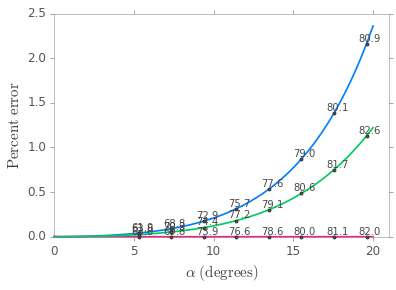

In [40]:
from matplotlib.ticker import FuncFormatter

zo = -509.0
f = 24.0
mpArr = [0.55, 1, 2.0]


fig, ax = plt.subplots(1, 1)
alphaExact = np.linspace(0.0001, 20)

for mp in mpArr:
    alphaApprox = []
    betaArr = []
    for alpha in alphaExact:
        beta = get_beta2(zo, f, mp, alpha)
        alphaApprox.append(alpha_approx(zo, f, mp, beta))
        betaArr.append(beta)
    alphaApprox = np.array(alphaApprox)
    err = np.abs(alphaExact - alphaApprox)
    relErr = 100.0*err/np.abs(alphaExact)#
    ax.plot(alphaExact, relErr, lw=1.7, clip_on=False)
    #ax.errorbar(alphaExact, relErr, xerr=0.0, yerr=err, clip_on=False)
    indices = np.argwhere(alphaExact > 5).flatten()[::5]
    ax.scatter(alphaExact[indices], relErr[indices], s=8, clip_on=False, 
               facecolor='#555555', edgecolor=None, zorder=10)
    for i in indices:
        ax.text(x=alphaExact[i]-0.5, y=relErr[i]+0.025, s='{:0.1f}'.format(betaArr[i]))
    
ax.set_ylabel(r'$\rm{Percent}\,\,\rm{error}$', fontsize=15)
ax.set_xlabel(r'$\alpha \,\,\rm(degrees)$', fontsize=15)
ax.set_xlim(alphaExact[0], alphaExact[-1] + 1)
ax.set_ylim(-0.001, 2.5)

#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Save the figure  
#saveFigure(fig, 'approximation_of_lens_tilt.png')

plt.show()

In [41]:
fl = 24.0
alphaOpt = -5.0
zo = -509.0
mp = 2.0
betaOpt = get_beta2(zo, fl, mp, alphaOpt)
print('beta_opt = ', betaOpt)
t = np.tan(np.deg2rad(betaOpt))

a = fl*mp*t
b = fl*t 
c = fl*(1-mp)/2.0
d = 0/2.0
e = mp*zo/2.0
f = 0

x = cosd(alphaOpt)
y = sind(alphaOpt)

print(a*x**2 + b*y**2 + 2*c*x*y + 2*d*x + 2*e*y + f)

print(t + sind(alphaOpt)*(mp*zo + fl*(1-mp)*cosd(alphaOpt))/(fl*(mp*cosd(alphaOpt)**2 + sind(alphaOpt)**2)))

beta_opt =  -62.2296825491
-5.68434188608e-14
-4.4408920985e-16


## Iterative algorithm for finding lens tilt angle $\alpha$

#### Condition for real image

The following cell shows that even if $F(\alpha)$ is monotonic, a combination of lens parameters and object plane distance could result in the case in which $\acute{z}_o$ is negative. We would like to avoid such cases.

abs(zo)*mp - f/cosd(alpha) =  1.38928453723
zeDash = 821.393942117
beta = -6.71908410729
roots = [-0.91827768+0.j          1.02408565+0.12702358j  1.02408565-0.12702358j]


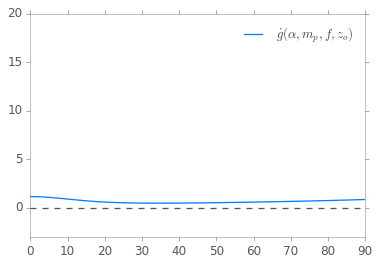

In [42]:
#zo=-539.359427021; f=89.8074019381; mp=0.155474178141; alpha=-6.10160377014;    # Image is virtual, zeDash is -ve
#zo=-539.359427021; f=83.38141419767325; mp=0.155474178141; alpha=-6.10160377014;  # Image at infinity
zo=-539.359427021; f=82; mp=0.155474178141; alpha=-6.10160377014;

print('abs(zo)*mp - f/cosd(alpha) = ', abs(zo)*mp - f/cosd(alpha))
# setting d=0, because I am just interested in zeDash

print('zeDash =', get_zoDash2(zo, f, mp, 0, alpha)) 

beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alpha)
print('beta =', beta)
roots, disc = roots_first_derivative_Falpha(zo, f, mp)
print('roots =', roots)

alpha = np.linspace(0., 89.9999, 1000)
plt.plot(alpha, first_derivative_Falpha(zo, f, mp, alpha), label=r'$\dot{g}(\alpha, m_p, f, z_o)$')
#plt.plot(alpha, get_beta2(zo, f, mp, alpha), label='beta')
ax = plt.gca()
ax.axhline(color='#555555', linestyle='dashed')
#ax.set_ylim(-3, 60)
ax.set_ylim(-3, 20)
ax.legend()
plt.show()

#### An iterative procedure to find $\alpha$

A possible algorithm for finding $\alpha$ given $\beta$.

In [43]:
def alpha_thin(zo, f, beta):
    return -arcsind(f*tand(beta)/zo)

In [44]:
zo = -509.0
f = 24.0   # 100
mp = 0.55
alphaTrue = -15.0

# CONDITION #1
# first ensure that F(alpha) is monotonic for the given parameters 
if first_derivative_has_real_positive_roots(zo, f, mp):
    assert False, "F(alpha) is not monotonic. Cannot find a unique alpha!"
else:
    roots, disc = roots_first_derivative_Falpha(zo, f, mp)
    print('roots', roots)
    
# CONDITION #2
assert (abs(zo)*mp - f/cosd(alphaTrue)) > 0.0, 'zeDash is negative; Image is not real'

# Generate a beta
beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alphaTrue)

# -------------------------------
# Main procedure starts here 

alphaInit = alpha_thin(zo=zo, f=f, beta=beta)

print('alpha (true) = ', alphaTrue)
print('beta =', beta)
print('Initial alpha = ', alphaInit)

errValStop = 1e-16
stepThreshold = 10
i = 0
t = tand(beta)
s = sind(alphaInit)
c = cosd(alphaInit)
prevErr = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
#prevErr = beta + arctand(s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))) # Initial merit function value
alpha_i = alphaInit
step = 0.5*prevErr

print("Initial error = ", prevErr)
print("np.arctan(prevErr) = ", np.arctan(prevErr))
print('Initial step = ', step)
print('np.arctan(step) =', np.arctan(step))
print()

while (abs(prevErr) > errValStop) and (i < stepThreshold):
    i += 1
    alpha_i += step 
    s = sind(alpha_i)
    c = cosd(alpha_i)
    err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
    #err = beta + arctand(s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)))
    deltaErr = err - prevErr   
    print('-------------')
    print('err({}) = {:2.4f}'.format(i, err))
    print('deltaErr({}) = {:2.4f}'.format(i, deltaErr))
    print('prevErr({}) = {:2.4f}'.format(i, prevErr))
    print('alpha({}) = {:2.4f}'.format(i, alpha_i))
    if np.sign(err)/np.sign(prevErr) < 0: # modify step direction and possibly size only if i > 0
        step = 0.5*deltaErr
        print('**Sign change: changing step to ', step)
    prevErr = err
    
print('Value of alpha after {} iterations = {:2.5f} (error = {:2.5e}, merit = {:2.5e})'
      .format(i, alpha_i, alphaTrue - alpha_i, err))

roots [ 0.19784279+0.53578773j  0.19784279-0.53578773j -0.26280472+0.j        ]
alpha (true) =  -15.0
beta = -78.7120373048
Initial alpha =  -13.6639828387
Initial error =  -0.398361241047
np.arctan(prevErr) =  -0.379092856052
Initial step =  -0.199180620523
np.arctan(step) = -0.196607570966

-------------
err(1) = -0.3382
deltaErr(1) = 0.0602
prevErr(1) = -0.3984
alpha(1) = -13.8632
-------------
err(2) = -0.2782
deltaErr(2) = 0.0599
prevErr(2) = -0.3382
alpha(2) = -14.0623
-------------
err(3) = -0.2186
deltaErr(3) = 0.0596
prevErr(3) = -0.2782
alpha(3) = -14.2615
-------------
err(4) = -0.1593
deltaErr(4) = 0.0594
prevErr(4) = -0.2186
alpha(4) = -14.4607
-------------
err(5) = -0.1002
deltaErr(5) = 0.0591
prevErr(5) = -0.1593
alpha(5) = -14.6599
-------------
err(6) = -0.0414
deltaErr(6) = 0.0588
prevErr(6) = -0.1002
alpha(6) = -14.8591
-------------
err(7) = 0.0171
deltaErr(7) = 0.0585
prevErr(7) = -0.0414
alpha(7) = -15.0582
**Sign change: changing step to  0.029242889561
--------

##### Testing the algorithm

In [45]:
def estimate_alpha(zo, f, mp, beta, maxSteps=250, errThreshold=1e-16, retSteps=False):
    """
    """
    assert g_of_alpha_is_monotonic(zo, f, mp), 'g(alpha) is not monotonic'
    errValStop = errThreshold
    stepThreshold = maxSteps
    alphas = []
    i = 0
    t = tand(beta)
    alphaInit = alpha_thin(zo=zo, f=f, beta=beta)
    alphas.append(alphaInit)
    s = sind(alphaInit)
    c = cosd(alphaInit)
    prevErr = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
    alpha_i = alphaInit
    step = 0.5*prevErr

    while (abs(prevErr) > errValStop) and (i < stepThreshold):
        i += 1
        alpha_i += step 
        s = sind(alpha_i)
        c = cosd(alpha_i)
        if retSteps:
            alphas.append(alpha_i)
        err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
        deltaErr = err - prevErr   
        if np.sign(err)/np.sign(prevErr) < 0: 
            step = 0.5*deltaErr
        prevErr = err
    if retSteps:
        return alpha_i, i, err, alphas
    else:
        return alpha_i, i, err

In [46]:
for i in range(6000):
    mp = 0.1 + 4*np.random.random() 
    zo = -500 - 1000*np.random.random()
    f = 50 + 50*np.random.random()
    
    # Ensure that there is a unique alpha within +/-90° for the parameters
    #if first_derivative_has_real_positive_roots(zo, f, mp):
    #    continue  
    
    if not g_of_alpha_is_monotonic(zo, f, mp):
        continue
    
    # generate a "True" alpha that we would like to determine
    alpha = (-1)**np.random.randint(1,3) * 30*np.random.random()
    
    # Ensure that the condition for real imaging is satisfied
    if (abs(zo)*mp - f/cosd(alpha)) <= 0.0:
        continue
    
    # generate the beta corresponding to the true alpha
    beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alpha)

    #     
    alphaEst, numSteps, _ = estimate_alpha(zo=zo, f=f, mp=mp, beta=beta)
    if abs(alpha - alphaEst) > 1e-5:
        print()
        print('mp = {}; zo = {}; f = {}; alpha = {}'.format(mp, zo, f, alpha))
        print('alpha (actual) = {:2.4f}; alpha (est) = {:2.4f}; steps = {}; error = {:2.2e}'
              .format(alpha, alphaEst, numSteps, alpha - alphaEst))


mp = 0.100040611322; zo = -1155.40058321; f = 90.03256459; alpha = -24.4437624965
alpha (actual) = -24.4438; alpha (est) = -24.4567; steps = 250; error = 1.30e-02

mp = 0.234238374715; zo = -504.870187989; f = 89.2661312709; alpha = 21.1877861028
alpha (actual) = 21.1878; alpha (est) = 21.1873; steps = 250; error = 5.15e-04

mp = 0.141434308842; zo = -591.286612058; f = 69.7462988441; alpha = -28.2099956153
alpha (actual) = -28.2100; alpha (est) = -28.2098; steps = 250; error = -1.97e-04

mp = 0.116167635781; zo = -1100.95300032; f = 88.1422611274; alpha = 28.1990924186
alpha (actual) = 28.1991; alpha (est) = 28.3572; steps = 250; error = -1.58e-01

mp = 0.158299531837; zo = -649.882117699; f = 82.6851837007; alpha = -28.3482543539
alpha (actual) = -28.3483; alpha (est) = -28.3482; steps = 250; error = -9.02e-05

mp = 0.101296664951; zo = -781.883485171; f = 55.3996530073; alpha = -26.6493340784
alpha (actual) = -26.6493; alpha (est) = -26.7347; steps = 250; error = 8.54e-02

mp = 0.1

In [47]:
#mp = 0.55; zo = -509.0; f = 24.0; alphaTrue = -15.0 
mp = 0.3735; zo = -509; f = 24; alphaTrue = 30

print('g_of_alpha_is_monotonic:', g_of_alpha_is_monotonic(zo, f, mp))
print('first_derivative_has_real_positive_roots:', first_derivative_has_real_positive_roots(zo, f, mp))
beta = get_beta2(zo=zo, f=f, mp=mp, alpha=alphaTrue)
alphaEst, numSteps, err, alphas = estimate_alpha(zo, f, mp, beta, errThreshold=1e-1, retSteps=True)
print('alpha est ', alphaEst)
print('steps ', numSteps)

g_of_alpha_is_monotonic: True
first_derivative_has_real_positive_roots: False
alpha est  29.6920771165
steps  14


In [48]:
alphas

[19.156316698, 19.9088710136, 20.6614253292, 21.4139796448, 22.1665339604, 22.919088276, 23.6716425916, 24.4241969072, 25.1767512228, 25.9293055384, 26.681859854, 27.4344141696, 28.1869684852, 28.9395228009, 29.6920771165]